In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bot-iot/data_26.csv
/kaggle/input/bot-iot/data_33.csv
/kaggle/input/bot-iot/data_49.csv
/kaggle/input/bot-iot/data_44.csv
/kaggle/input/bot-iot/data_38.csv
/kaggle/input/bot-iot/data_22.csv
/kaggle/input/bot-iot/data_30.csv
/kaggle/input/bot-iot/data_57.csv
/kaggle/input/bot-iot/data_46.csv
/kaggle/input/bot-iot/data_58.csv
/kaggle/input/bot-iot/data_21.csv
/kaggle/input/bot-iot/data_59.csv
/kaggle/input/bot-iot/data_32.csv
/kaggle/input/bot-iot/data_69.csv
/kaggle/input/bot-iot/data_19.csv
/kaggle/input/bot-iot/data_47.csv
/kaggle/input/bot-iot/data_14.csv
/kaggle/input/bot-iot/data_9.csv
/kaggle/input/bot-iot/data_52.csv
/kaggle/input/bot-iot/data_18.csv
/kaggle/input/bot-iot/data_53.csv
/kaggle/input/bot-iot/data_73.csv
/kaggle/input/bot-iot/data_63.csv
/kaggle/input/bot-iot/data_70.csv
/kaggle/input/bot-iot/data_17.csv
/kaggle/input/bot-iot/data_7.csv
/kaggle/input/bot-iot/data_67.csv
/kaggle/input/bot-iot/data_names.csv
/kaggle/input/bot-iot/data_11.csv
/kaggle/input

In [2]:
# import os
# import pandas as pd

# data_dir = "/kaggle/input/bot-iot"
# csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
# print(f"Found {len(csv_files)} CSV files")

In [3]:
# sample_file = os.path.join(data_dir, csv_files[71])
# df_sample = pd.read_csv(sample_file, nrows=5)
# print(df_sample.columns)
# print(df_sample.head())

# check the files exist.. also see the sample format for reference..

In [4]:
import pandas as pd
sample_file = "/kaggle/input/bot-iot/data_11.csv"
sample_df = pd.read_csv(sample_file)
print(sample_df.memory_usage().sum() / (1024**3), "GB")  # Size in GB
print(sample_df.shape)  # Rows, columns

0.26077044010162354 GB
(1000000, 35)


# Using the dask based dataframe and parquent file for ensuring the size efficiency of the file and to be able to handle the low computation and ram of a avgerage system..  **Apache Parquet is an open source, column-oriented data file format designed for efficient data storage and retrieval.**  total dataset size is ~15 gb converted into ~1Gb(70%) of the dataset   

# dask approach

In [6]:
import dask.dataframe as dd
import pandas as pd

# Specify only the columns we need to reduce memory footprint
selected_columns = [
    'pkts', 'bytes', 'sbytes', 'dbytes', 'dur', 'rate', 'mean', 'stddev', 'sum', 
    'proto', 'state', 'stime', 'category'  # Ensure 'category' is included
]

# Load all CSV files with Dask
df = dd.read_csv("/kaggle/input/bot-iot/*.csv", usecols=selected_columns, dtype={'category': 'object'})

# Basic preprocessing (lazy evaluation)
df = df.dropna()  # Drops NaN rows when computed

# Encode categorical features (excluding 'category' to retain original class labels)
df['proto'] = df['proto'].map_partitions(lambda x: pd.Categorical(x).codes)
df['state'] = df['state'].map_partitions(lambda x: pd.Categorical(x).codes)

# Compute class distribution before encoding 'category'
class_counts = df['category'].value_counts().compute()

# Print class counts
print("Class Distribution:\n", class_counts)

# Encode 'category' after checking distributions
df['category'] = df['category'].map_partitions(lambda x: pd.Categorical(x, categories=class_counts.index).codes)

# Print preview of processed dataframe
print(df.head())


Class Distribution:
 category
DoS               33005194
Theft                 1587
DDoS              38532480
Normal                9543
Reconnaissance     1821639
Name: count, dtype: int64[pyarrow]
          stime  proto  pkts  bytes  state          dur      mean    stddev  \
0  1.526344e+09      0     4    240      0  1195.996582  0.000006  0.000002   
1  1.526344e+09      3    10    680      0  1453.945923  0.000028  0.000008   
2  1.526344e+09      4     2    180      0     0.048565  0.048565  0.000000   
3  1.526344e+09      0    10    510      0  1454.080322  0.000238  0.000022   
4  1.526344e+09      4     4    630      0   569.933960  0.098505  0.080150   

        sum  sbytes  dbytes       rate  category  
0  0.000011     120     120   0.002508         3  
1  0.000138     350     330   0.006190         3  
2  0.048565      90      90  20.590960         3  
3  0.001189     210     300   0.006189         3  
4  0.197011     174     456   0.005264         3  


In [7]:
import dask.dataframe as dd

# Define the path to CSV files
# csv_path = "/kaggle/input/bot-iot/*.csv"

# Read only the 'category' column, ensuring it's treated as a string
# df = dd.read_csv(csv_path, usecols=['category'], dtype={'category': 'object'})

# Compute category distribution


# Display class counts
print(df['category'].value_counts().compute())


category
4     1821639
3        9543
2    38532480
0    33005194
1        1587
Name: count, dtype: int64


# type casting to lower datatypes to make use of less memory(batch efficiency)

In [8]:

df = df.astype({
    'pkts': 'int16', 'bytes': 'int32', 'sbytes': 'int32', 'dbytes': 'int32',
    'dur': 'float32', 'rate': 'float32', 'mean': 'float32', 'stddev': 'float32', 'sum': 'float32',
    'proto': 'int8', 'state': 'int8', 'stime': 'float32', 'category': 'int8'
})

# down sizing the dataset using 70% of the dataset to ensure the organility

In [9]:
# For Dask
df = df.sample(frac=0.7, random_state=42)

In [10]:
df.to_parquet("/kaggle/working/processed_data.parquet")  # Dask
df = dd.read_parquet("/kaggle/working/processed_data.parquet")  # Reload later

# Dataset Info and checking for null values

In [11]:
import dask.dataframe as dd

# Load the Parquet file (if not already loaded)
df = dd.read_parquet("/kaggle/working/processed_data.parquet")

# Get basic information about the dataset
print(df.info())  # Check columns and data types
print(df.memory_usage(deep=True).compute())  # Check memory usage
print(df.head())  # Preview first few rows

# Check for missing values
missing_values = df.isnull().sum().compute()
print("Missing Values:\n", missing_values)


<class 'dask_expr.DataFrame'>
Columns: 13 entries, stime to category
dtypes: float32(6), int16(1), int32(3), int8(3)None
Index       410874432
stime       205437216
proto        51359304
pkts        102718608
bytes       205437216
state        51359304
dur         205437216
mean        205437216
stddev      205437216
sum         205437216
sbytes      205437216
dbytes      205437216
rate        205437216
category     51359304
dtype: int64
               stime  proto  pkts  bytes  state       dur      mean  stddev  \
31364   1.526348e+09      3     2    120      6  0.001669  0.001669     0.0   
269390  1.526881e+09      3     2    120      6  0.017652  0.017652     0.0   
129515  1.526355e+09      3     8    794      1  0.000748  0.000748     0.0   
218624  1.526881e+09      3     2    120      6  0.023921  0.023921     0.0   
184863  1.526881e+09      3     2    120      6  0.000721  0.000721     0.0   

             sum  sbytes  dbytes         rate  category  
31364   0.001669      60 

# class counts

In [12]:
# Compute class distribution
class_counts = df['category'].value_counts().compute()
print("Class Distribution:\n", class_counts)


Class Distribution:
 category
4     1275087
0    23103685
1        1116
2    26972709
3        6707
Name: count, dtype: int64


# numeric cols Distributions

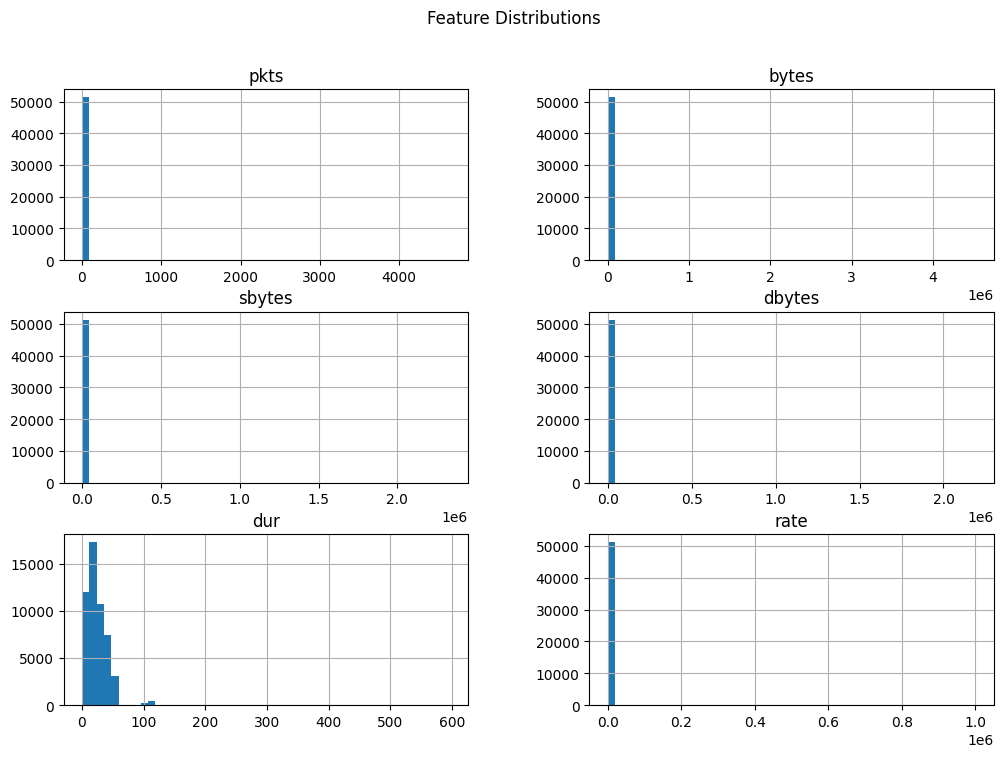

In [13]:
import matplotlib.pyplot as plt

# Select a few numeric columns to visualize
numeric_columns = ['pkts', 'bytes', 'sbytes', 'dbytes', 'dur', 'rate']

# Convert Dask DF to Pandas (for small samples)
sample_df = df[numeric_columns].sample(frac=0.001, random_state=42).compute()

# Plot histograms
sample_df.hist(figsize=(12, 8), bins=50)
plt.suptitle("Feature Distributions")
plt.show()


# Correlation b/w numeric cols 

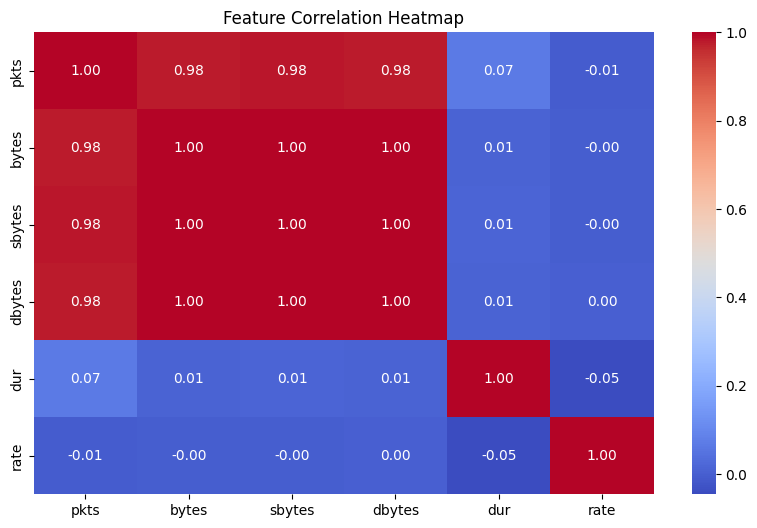

In [14]:
import seaborn as sns

# Compute a small sample for correlation analysis
corr_sample = df[numeric_columns].sample(frac=0.001, random_state=42).compute()

# Compute correlation matrix
correlation_matrix = corr_sample.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


# Detect and Handle Skewed Features

Feature Skewness:
 pkts      208.953709
bytes     225.877455
sbytes    225.385713
dbytes    225.216314
dur         2.932209
rate      106.814278
dtype: float64


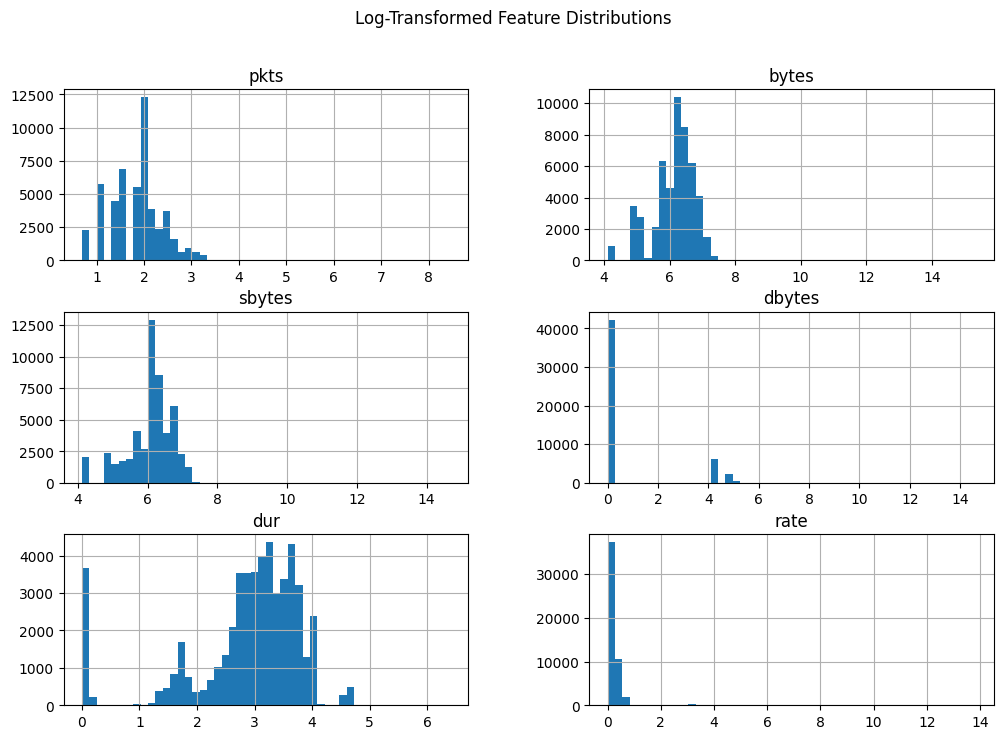

In [15]:
from scipy.stats import skew

# Check skewness of numeric features
skewness = sample_df.skew()
print("Feature Skewness:\n", skewness)

# Apply log transformation if necessary
for col in skewness[abs(skewness) > 1].index:
    sample_df[col] = sample_df[col].apply(lambda x: np.log1p(x))  # Log transformation

# Plot transformed distributions
sample_df.hist(figsize=(12, 8), bins=50)
plt.suptitle("Log-Transformed Feature Distributions")
plt.show()


# Class Distribution (Bar Chart)

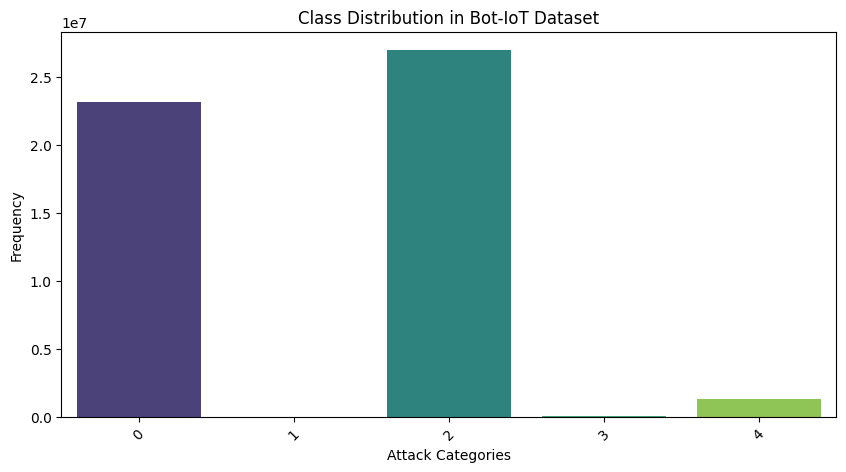

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute class distribution
class_counts = df['category'].value_counts().compute()

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Attack Categories")
plt.ylabel("Frequency")
plt.title("Class Distribution in Bot-IoT Dataset")
plt.xticks(rotation=45)
plt.show()


# Feature Distributions (Histograms)

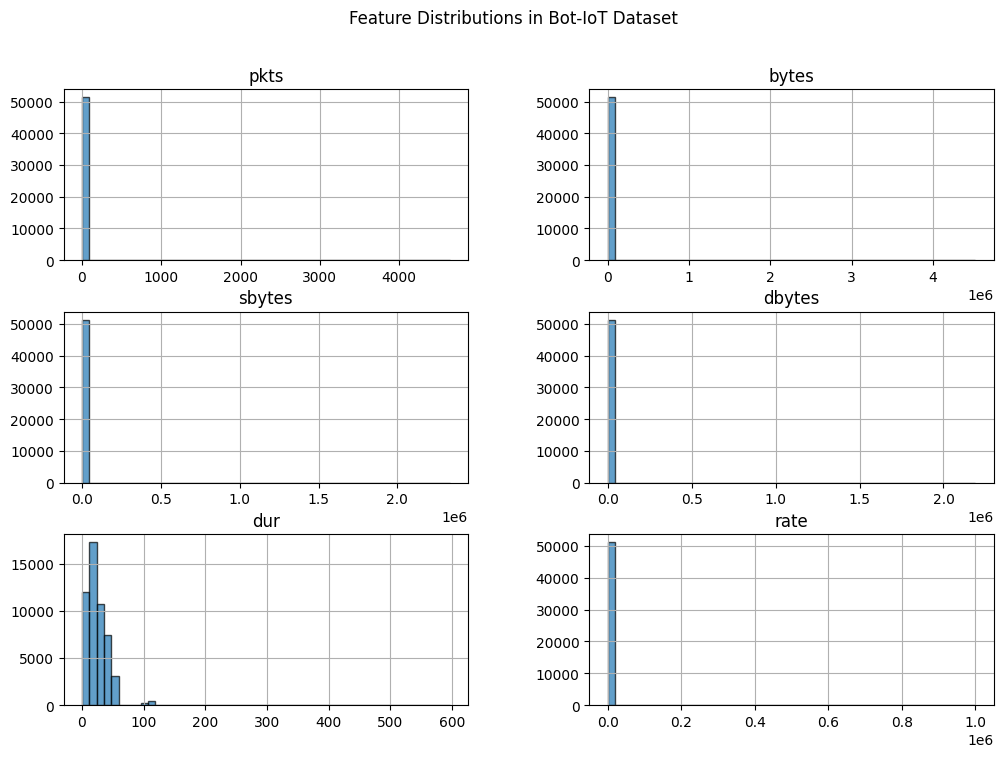

In [17]:
# Select numeric columns
numeric_columns = ['pkts', 'bytes', 'sbytes', 'dbytes', 'dur', 'rate']

# Compute a small sample for visualization
sample_df = df[numeric_columns].sample(frac=0.001, random_state=42).compute()

# Plot histograms
sample_df.hist(figsize=(12, 8), bins=50, edgecolor='black', alpha=0.7)
plt.suptitle("Feature Distributions in Bot-IoT Dataset")
plt.show()


# Boxplots to Identify Outliers

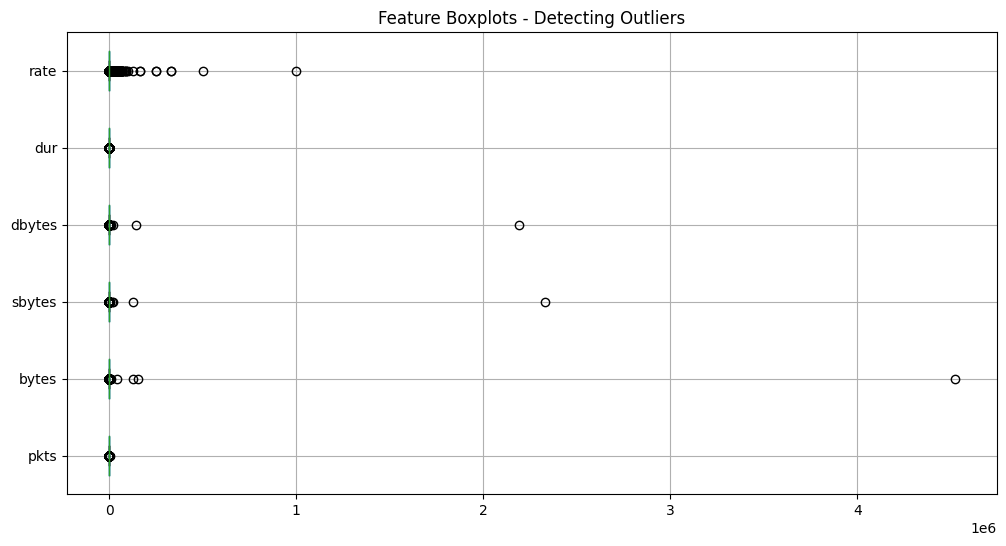

In [18]:
# Plot boxplots for numeric features
plt.figure(figsize=(12, 6))
sample_df.boxplot(column=numeric_columns, vert=False)
plt.title("Feature Boxplots - Detecting Outliers")
plt.show()


# Pairplot for Feature Relationships

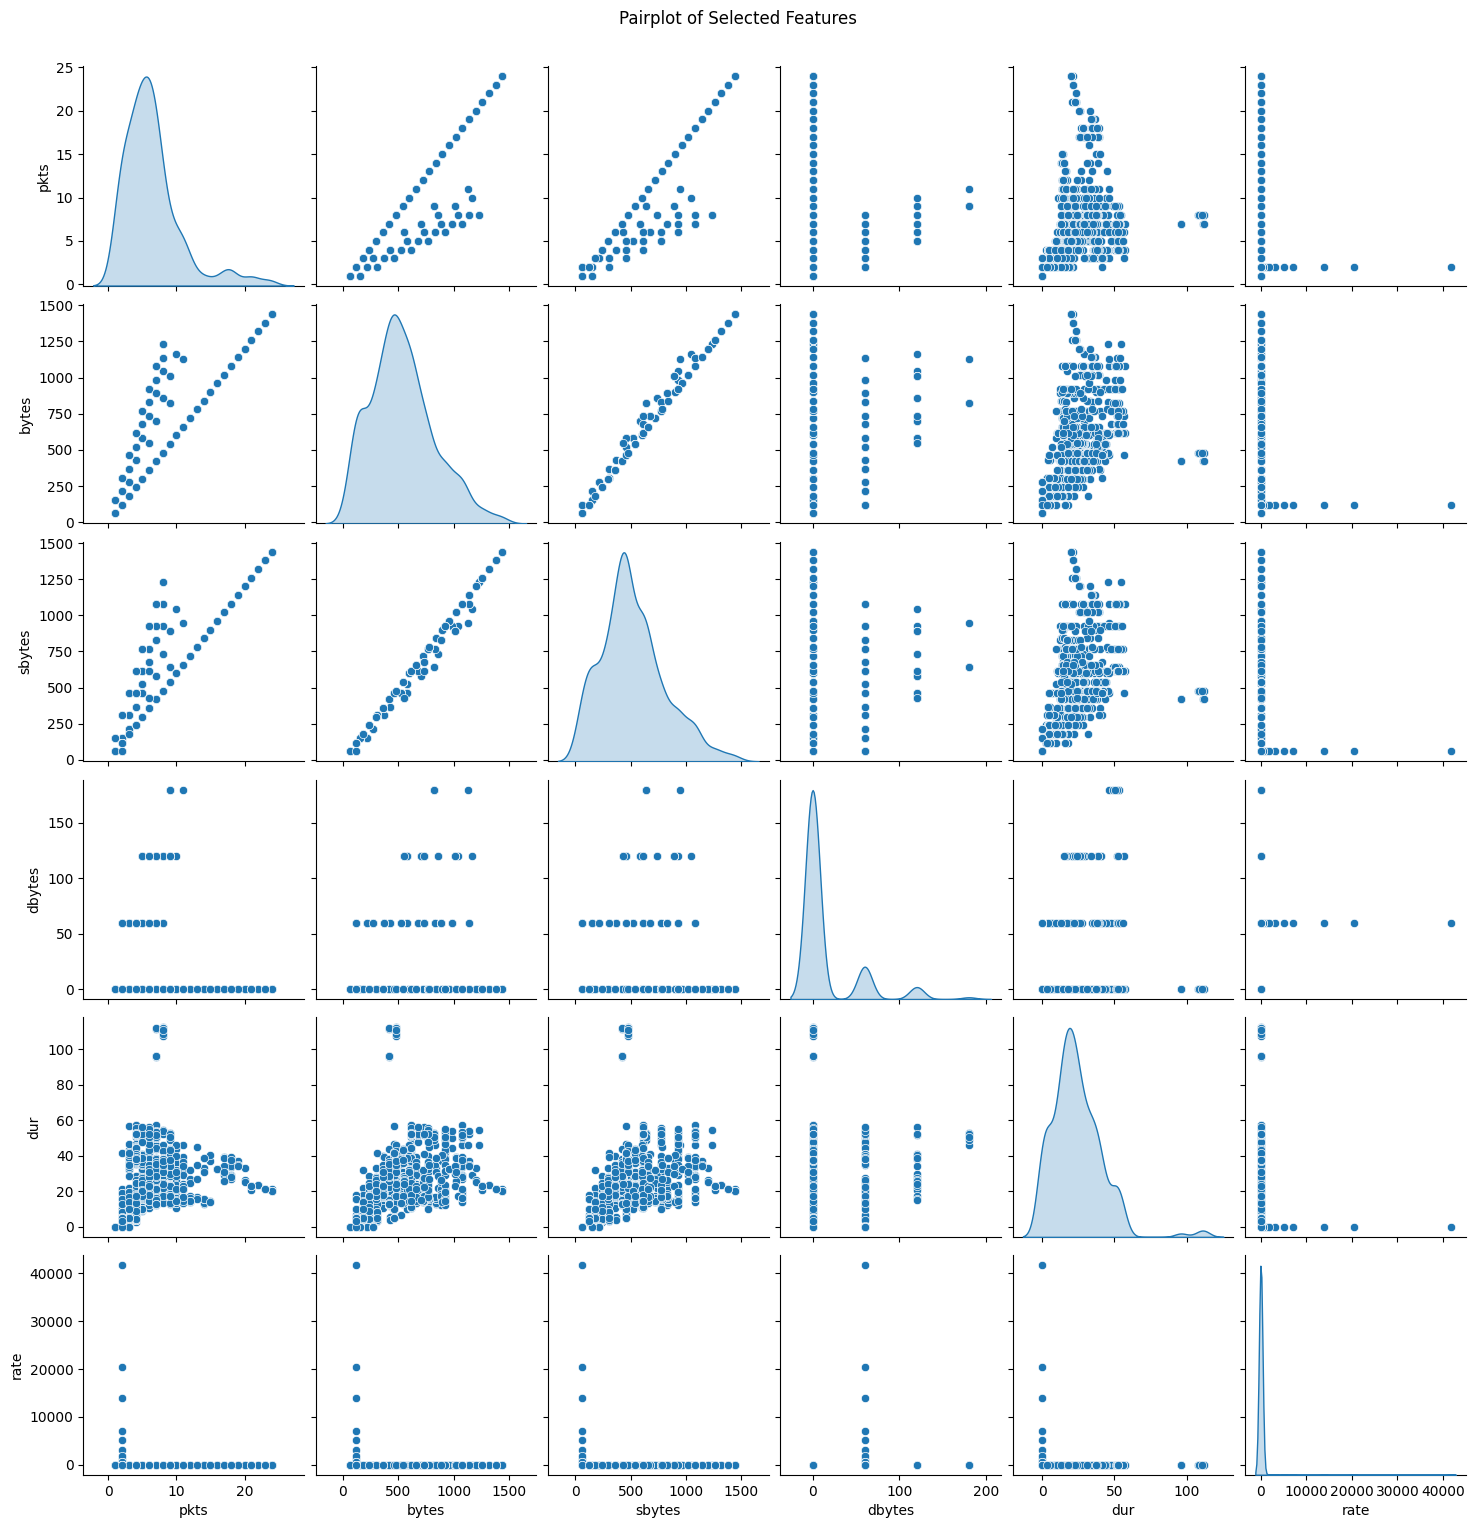

In [19]:
import seaborn as sns

# Take a small sample for visualization
sample_df = sample_df.sample(1000, random_state=42)  # Reduce size for visualization

# Pairplot
sns.pairplot(sample_df, diag_kind='kde')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()


# Distribution of Packet Durations Across Attack Types


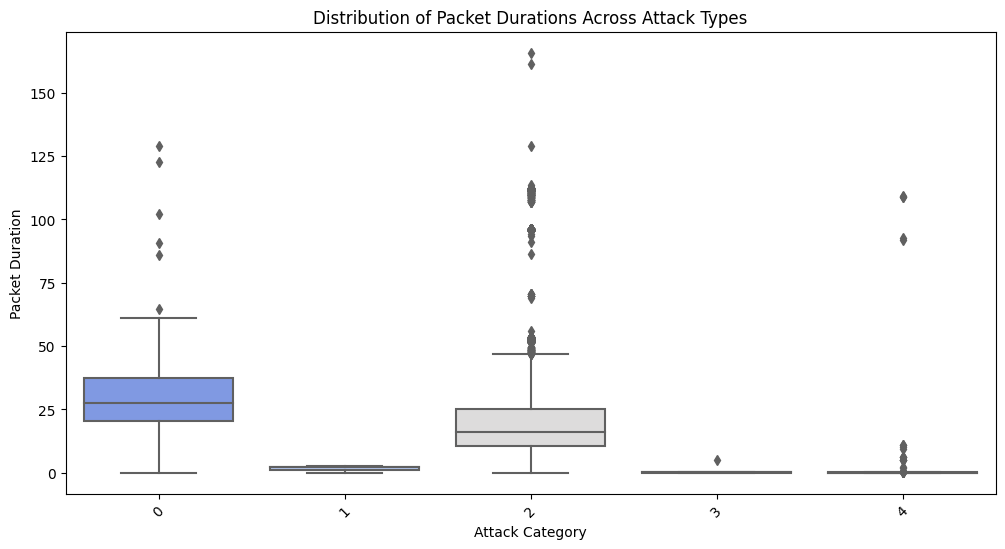

In [20]:
# Convert to Pandas before plotting
df_sample = df[['category', 'dur']].sample(frac=0.001, random_state=42).compute()

# Now, plot using Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_sample['category'], y=df_sample['dur'], palette="coolwarm")
plt.xlabel("Attack Category")
plt.ylabel("Packet Duration")
plt.title("Distribution of Packet Durations Across Attack Types")
plt.xticks(rotation=45)
plt.show()


# Protocol Usage in Different Attacks

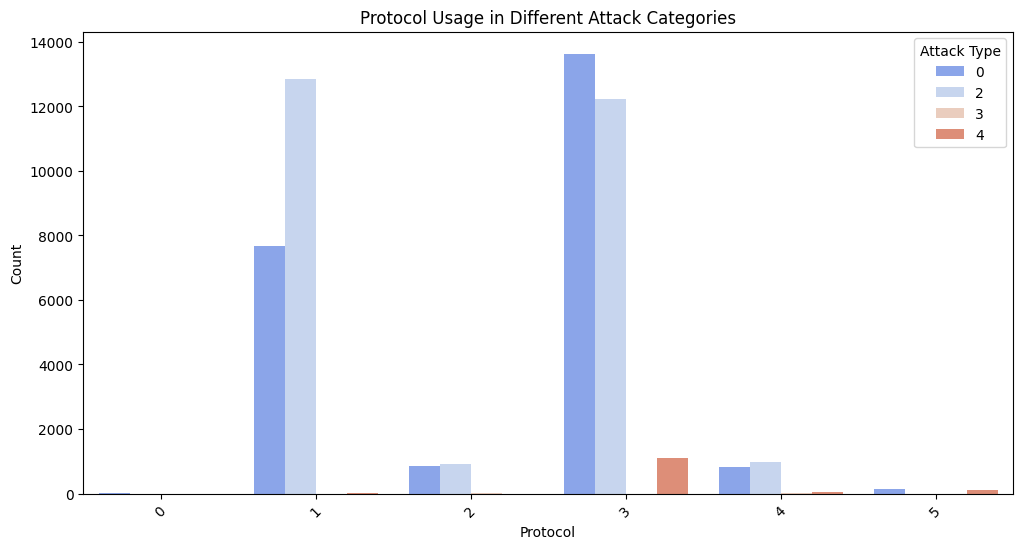

In [21]:
# Sample data for better visualization
sample_df = df.sample(frac=0.001, random_state=42).compute()

# Countplot for protocol usage
plt.figure(figsize=(12, 6))
sns.countplot(x='proto', hue='category', data=sample_df, palette="coolwarm")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.title("Protocol Usage in Different Attack Categories")
plt.xticks(rotation=45)
plt.legend(title="Attack Type", bbox_to_anchor=(1, 1))
plt.show()


# Check the class distribution

In [22]:
import dask.dataframe as dd

# Load the Parquet file using Dask
df = dd.read_parquet("/kaggle/working/processed_data.parquet")

# Compute class distribution
class_counts = df['category'].value_counts().compute()

# Print class counts
print(class_counts)


category
4     1275087
0    23103685
1        1116
2    26972709
3        6707
Name: count, dtype: int64


In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Compute Dask DataFrame to pandas (after filtering/sampling)
df = df.compute()  # Ensure this fits in ~15 GB post-optimization

# Split features and target
# X = df.drop(columns=['category']).values
# y = df['category'].values

# # Convert to tensors
# X_tensor = torch.FloatTensor(X)
# y_tensor = torch.LongTensor(y)

# # Create DataLoader
# dataset = TensorDataset(X_tensor, y_tensor)
# train_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)  # Use 2 workers for Kaggle CPU

# Check the memory usage make shure we dont crash on ram

In [24]:
import psutil
print(f"Memory used: {psutil.virtual_memory().percent}%")

Memory used: 21.4%


# Feature extraction using tree based classifer and l1 regularization (since  dealing with high-dimensional datasets, noisy data, and situations where computational efficiency is essential.)

Sampling from data_26.csv...
Sampling from data_33.csv...
Sampling from data_49.csv...
Sampling from data_44.csv...
Sampling from data_38.csv...
Sampling from data_22.csv...
Sampling from data_30.csv...
Sampling from data_57.csv...
Sampling from data_46.csv...
Sampling from data_58.csv...
Sampling from data_21.csv...
Sampling from data_59.csv...
Sampling from data_32.csv...
Sampling from data_69.csv...
Sampling from data_19.csv...
Sampling from data_47.csv...
Sampling from data_14.csv...
Sampling from data_9.csv...
Sampling from data_52.csv...
Sampling from data_18.csv...
Sampling from data_53.csv...
Sampling from data_73.csv...
Sampling from data_63.csv...
Sampling from data_70.csv...
Sampling from data_17.csv...
Sampling from data_7.csv...
Sampling from data_67.csv...
Sampling from data_names.csv...
Sampling from data_11.csv...
Sampling from data_36.csv...
Sampling from data_37.csv...
Sampling from data_40.csv...
Sampling from data_66.csv...
Sampling from data_24.csv...
Sampling from

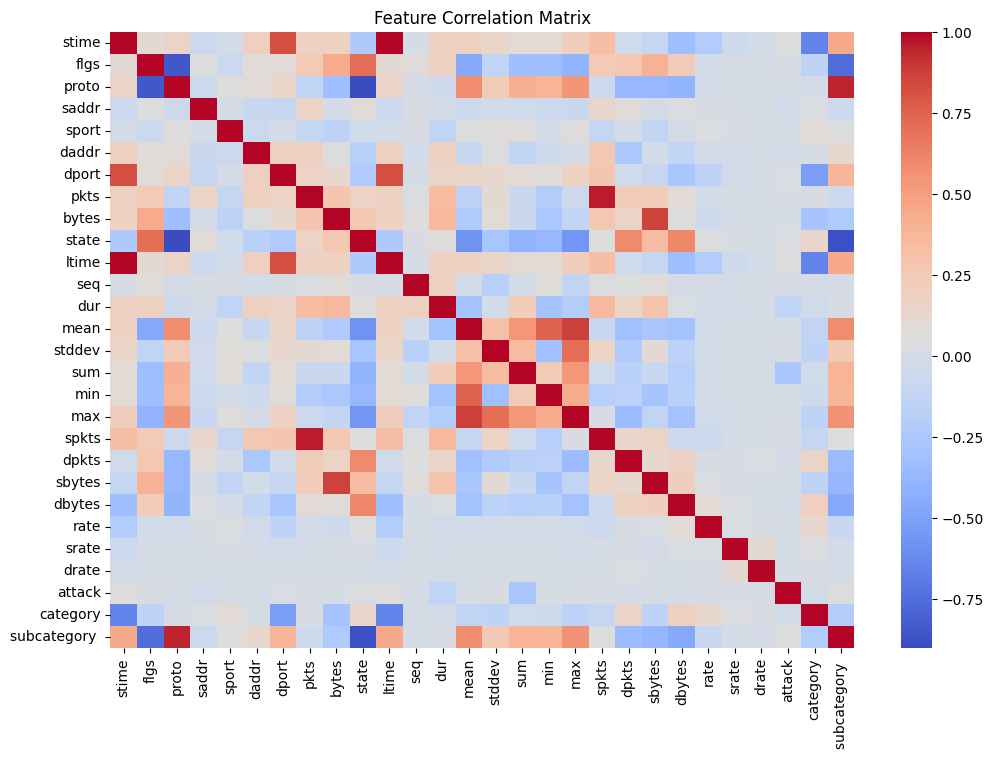

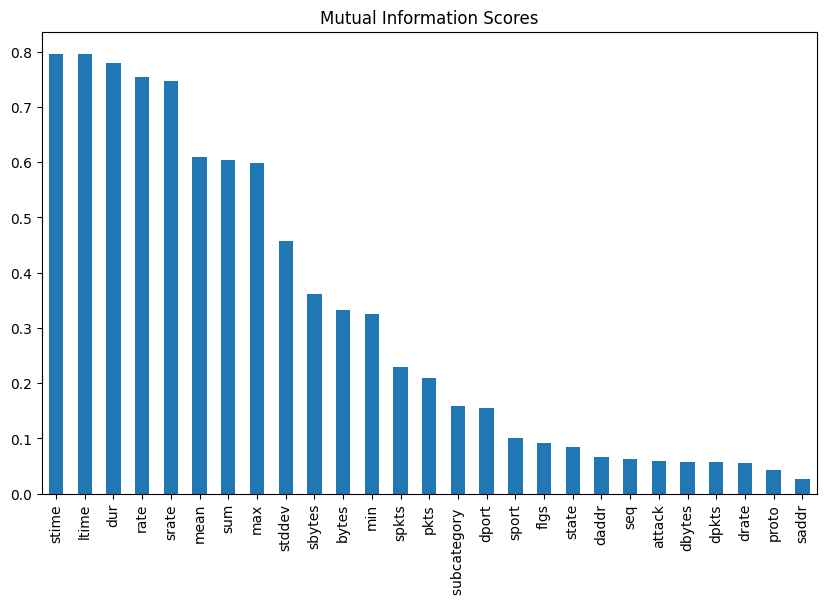

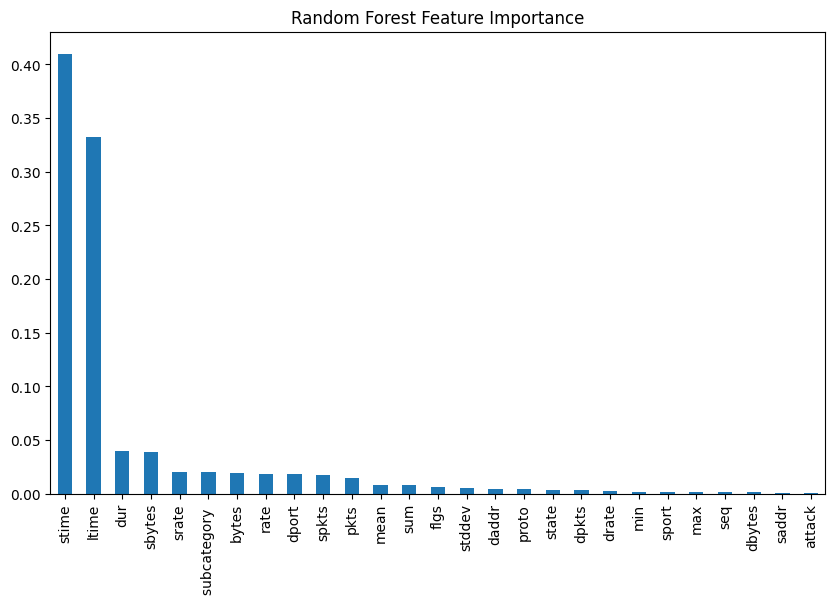

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e+04, tolerance: 2.028e+01
  model = cd_fast.enet_coordinate_descent(


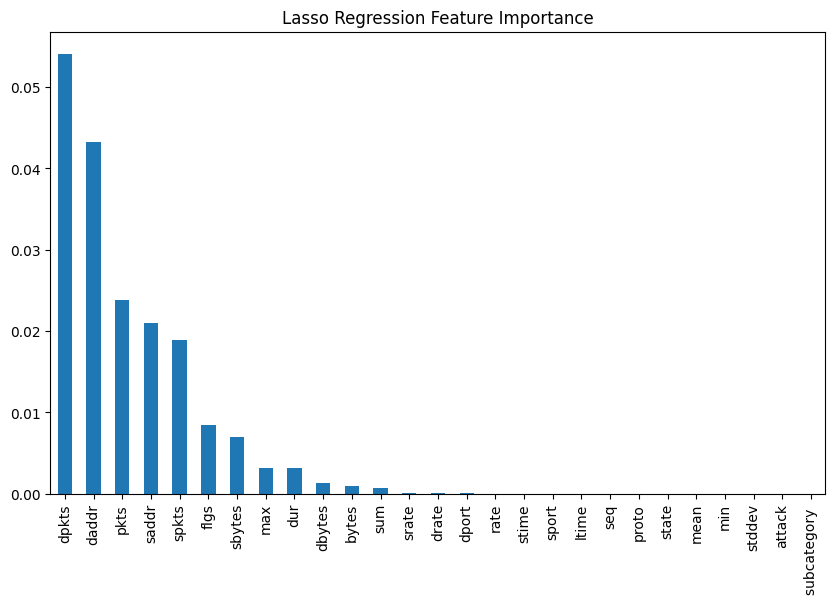

In [25]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt

# Path to folder containing multiple CSV files
data_folder = '/kaggle/input/bot-iot'  # Update with your folder path

# Read a sample from all CSVs to analyze feature importance
sample_size = 500000  # Adjust based on memory
all_data = []

def sample_data(file_path, sample_size):
    chunk = pd.read_csv(file_path, nrows=sample_size, low_memory=False)
    return chunk

for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_folder, filename)
        print(f"Sampling from {filename}...")
        df_sample = sample_data(file_path, sample_size // len(os.listdir(data_folder)))
        all_data.append(df_sample)

# Merge sampled data
df = pd.concat(all_data, ignore_index=True)

# Remove unnecessary columns
null_cols = ['dco', 'sco', 'doui', 'soui', 'dmac', 'smac']  # Replace with actual null columns
df.drop(columns=['pkSeqID'] + null_cols, inplace=True, errors='ignore')

# Remove rows with missing values
df.dropna(inplace=True)

# Detect categorical columns dynamically
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert categorical columns to strings before encoding
for col in categorical_cols:
    df[col] = df[col].astype(str)

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define target variable
X = df.drop(columns=['category'])  # Update 'Label' to actual target column
y = df['category']

# Correlation Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

# Mutual Information
mi_scores = mutual_info_classif(X, y, discrete_features=False)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
mi_scores.plot(kind='bar')
plt.title("Mutual Information Scores")
plt.show()

# Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X, y)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Random Forest Feature Importance")
plt.show()

# Lasso Regression for Feature Selection
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
lasso_importance = pd.Series(np.abs(lasso.coef_), index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lasso_importance.plot(kind='bar')
plt.title("Lasso Regression Feature Importance")
plt.show()

# Select the Top 10 Most Important Features
# top_features = feature_importances.head(10).index.tolist()
# print("Top 10 Selected Features:", top_features)


In [26]:
# Get top 10 features from both methods
rf_top_features = set(feature_importances.head(10).index.tolist())
lasso_top_features = set(lasso_importance.head(10).index.tolist())

print("Top 10 Selected Features (Intersection of RF and Lasso):", rf_top_features)
print("Top 10 Selected Features (Intersection of RF and Lasso):", lasso_top_features)

# Find the intersection
top_features = rf_top_features.intersection(lasso_top_features)

print("Top 10 Selected Features (Intersection of RF and Lasso):", top_features)


Top 10 Selected Features (Intersection of RF and Lasso): {'dur', 'ltime', 'bytes', 'subcategory ', 'sbytes', 'dport', 'rate', 'stime', 'spkts', 'srate'}
Top 10 Selected Features (Intersection of RF and Lasso): {'dpkts', 'pkts', 'max', 'dur', 'saddr', 'flgs', 'sbytes', 'spkts', 'dbytes', 'daddr'}
Top 10 Selected Features (Intersection of RF and Lasso): {'sbytes', 'spkts', 'dur'}


# the below feature that are selected are the combination from feature selection process and Domain knowledge ..

In [32]:
df = dd.read_parquet("/kaggle/working/processed_data.parquet")  

# current data preprocessing appraoch.. 
#** intial dataset distributions
 Class 0: ~450,000 samples
Class 1: 22 samples
Class 2: ~525,000 samples
Class 3: ~124 samples
Class 4: ~25,000 samples

then test set is defined as follewed:
thing is 

Using the proportions from the test set:

Class 0: 
(449,939/1,000,000)×4,000,000 ≈ 1,799,756

Class 1: 
(22/1,000,000)×4,000,000 ≈ 88

Class 2: 
(525,176/1,000,000) ×4,000,000 ≈  2,100,704

Class 3: 
(124/1,000,000)×4,000,000 ≈ 496

Class 4: 
(24,739/1,000,000) ×4,000,000 ≈98,956

SO training set  before sampling were
 Class 0: 1,799,756 (~45.0%)
 Class 1: 88 (~0.002%)
 Class 2: 2,100,704 (~52.5%)
 Class 3: 496 (~0.012%)
 Class 4: 98,956 (~2.5%)

 step2: under sampling the majority class
  RandomUnderSampler to undersample the majority classes (Classes 0, 2, and 4) to 50,000 samples each
  Class Distribution After Undersampling:

Class 0: 50,000 (~49.2%)
Class 1: 88 (~0.09%)
Class 2: 50,000 (~49.2%)
Class 3: 496 (~0.49%)
Class 4: 50,000 (~49.2%)
Total samples: 50,000 + 88 + 50,000 + 496 + 50,000 = 150,584


step3: oversampling with the adasyn due to the (reason:Unlike SMOTE, which generates synthetic samples uniformly across the feature space, ADASYN focuses on generating more synthetic samples for minority instances that are harder to classify correctly, based on their level of difficulty in classification)

Final Class Distribution in Training Set (After ADASYN):

Class 0: 50,000 (~12.5%)
Class 1: 75,000 (~18.75%)
Class 2: 50,000 (~12.5%)
Class 3: 125,000 (~31.25%)
Class 4: 75,000 (~18.75%)
Total samples: 50,000 + 75,000 + 50,000 + 125,000 + 75,000 = 375,000

# Current SB

In [28]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
import gc

# Step 1: Inspect the 'category' column
print("Unique values in 'category':", np.unique(df['category']))
print("Class distribution before sampling:\n", df['category'].value_counts())

# Step 2: Combine with Chebyshev distance
X_static = np.array(df[['pkts', 'bytes', 'sbytes', 'dbytes', 'rate', 'mean', 'stddev', 'sum', 'proto', 'state']].values, dtype=np.float32)
X_temporal = np.array(df[['stime', 'dur']].values, dtype=np.float32)
X_static_mean = X_static.mean(axis=1)
X_static_std = X_static.std(axis=1)
X_static_reduced = np.vstack([X_static_mean, X_static_std]).T
chebyshev_dist = np.max(np.abs(X_static_reduced - X_temporal), axis=1)
X_combined = np.hstack((X_static, chebyshev_dist.reshape(-1, 1)))
y = np.array(df['category'].values, dtype=np.int64)

# Free memory
del df, X_static, X_temporal, X_static_mean, X_static_std, X_static_reduced, chebyshev_dist
gc.collect()

# Step 3: Sample to reduce size (target ~5M samples total)
np.random.seed(42)
sample_indices = np.random.choice(len(X_combined), size=5_000_000, replace=False)
X_combined = X_combined[sample_indices]
y = y[sample_indices]

# Compute class distribution after sampling
class_counts_sampled = np.bincount(y)
print("Class distribution after sampling:", {i: count for i, count in enumerate(class_counts_sampled)})

# Step 4: Train-test split BEFORE sampling
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Free memory
del X_combined, y
gc.collect()

# Compute class distribution in training set
class_counts_train = np.bincount(y_train)
print("Class distribution in training set:", {i: count for i, count in enumerate(class_counts_train)})

# Step 5: Hybrid Sampling to Balance the Training Set
# 5.1: Undersample the majority classes (Classes 0, 2, and 4)
undersampler = RandomUnderSampler(
    sampling_strategy={
        0: 50_000,  # Target 50K for Class 0
        2: 50_000,  # Target 50K for Class 2
        4: 50_000   # Target 50K for Class 4
    },
    random_state=42
)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Free memory
del X_train, y_train
gc.collect()

# Compute class distribution after undersampling
class_counts_under = np.bincount(y_train_under)
print("Class distribution after undersampling:", {i: count for i, count in enumerate(class_counts_under)})

# 5.2: Apply ADASYN to oversample the minority classes (Classes 1, 3)
adasyn = ADASYN(
    random_state=42,
    sampling_strategy={
        0: 50_000,  # Already at 50K
        1: 75_000,  # Oversample to 75K
        2: 50_000,  # Already at 50K
        3: 100_000, # Further reduced oversampling for Class 3
        4: 75_000   # Already at 75K
    }
)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_under, y_train_under)

# Add random noise to synthetic samples to increase diversity
noise = np.random.normal(0, 0.02, X_train_resampled.shape)
X_train_resampled += noise

# Free memory
del X_train_under, y_train_under
gc.collect()

# Compute class distribution after ADASYN
class_counts_resampled = np.bincount(y_train_resampled)
print("Class distribution after ADASYN:", {i: count for i, count in enumerate(class_counts_resampled)})

# Step 6: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Free memory
del X_train_resampled, X_test
gc.collect()

# Step 7: Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# Free memory
del X_train_scaled, X_test_scaled, y_train_resampled, y_test
gc.collect()

# Step 8: Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=4)

print("Data loading complete! Ready for SpinalSAENet training.")

Unique values in 'category': [0 1 2 3 4]
Class distribution before sampling:
 Dask Series Structure:
npartitions=220
    int64
      ...
    ...  
      ...
      ...
Dask Name: valuecounts, 3 expressions
Expr=ReadParquetFSSpec(9e5c51f)['category'].valuecounts(split_out=True)
Class distribution after sampling: {0: 2249694, 1: 108, 2: 2625881, 3: 620, 4: 123697}
Class distribution in training set: {0: 1799755, 1: 86, 2: 2100705, 3: 496, 4: 98958}
Class distribution after undersampling: {0: 50000, 1: 86, 2: 50000, 3: 496, 4: 50000}
Class distribution after ADASYN: {0: 50000, 1: 75001, 2: 50000, 3: 100012, 4: 75050}
Data loading complete! Ready for SpinalSAENet training.


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha  # Class weights

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Define SpinalSAENet (unchanged)
class SpinalSAENet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], num_classes=5):
        super(SpinalSAENet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dims[1], 32),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.classifier(encoded)
        return output

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Compute input_dim and num_classes
input_dim = train_dataset.tensors[0].shape[1]  # 11
num_classes = len(torch.unique(train_dataset.tensors[1]))  # Should be 5
print(f"Input dimension: {input_dim}, Number of classes: {num_classes}")

# Initialize model
model = SpinalSAENet(input_dim, hidden_dims=[128, 64], num_classes=num_classes)
model = model.to(device)

# Class weights (logarithmic inverse frequency with adjustment for Class 3)
y_test = test_dataset.tensors[1].numpy()
class_counts = np.bincount(y_test)
print("Class distribution in test set:", {i: count for i, count in enumerate(class_counts)})
class_weights = np.log(1.0 / class_counts + 1e-6)  # Add small constant to avoid log(0)
class_weights = class_weights / class_weights.sum() * len(class_counts)
# Increase weight for Class 3
class_weights[3] *= 2.0  # Double the weight for Class 3
class_weights = torch.FloatTensor(class_weights).to(device)

# Use Focal Loss
criterion_clf = FocalLoss(alpha=class_weights, gamma=2.5)
optimizer_clf = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf, mode='min', factor=0.1, patience=3)
scaler = torch.cuda.amp.GradScaler()

print("Training Classifier...")
best_val_loss = float('inf')
patience_counter = 0
patience = 5  # Early stopping patience

for epoch in range(20):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        optimizer_clf.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(data)
            loss = criterion_clf(output, target)
        if torch.isnan(loss):
            print("NaN loss detected in training, skipping batch")
            continue
        scaler.scale(loss).backward()
        scaler.step(optimizer_clf)
        scaler.update()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    all_scores = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(data)
                loss = criterion_clf(outputs, target)
            val_loss += loss.item()
            # Apply threshold adjustment for Class 3
            probs = torch.softmax(outputs, dim=1)
            class_3_threshold = 0.7  # Increase threshold for Class 3
            probs[:, 3] = torch.where(probs[:, 3] >= class_3_threshold, probs[:, 3], torch.tensor(0.0, device=device))
            _, predicted = torch.max(probs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())  # Raw logits for ROC
    
    val_loss /= len(test_loader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_targets))
    f1_weighted = f1_score(all_targets, all_preds, average='weighted')
    f1_macro = f1_score(all_targets, all_preds, average='macro')
    precision, recall, f1_per_class, _ = precision_recall_fscore_support(all_targets, all_preds, average=None, zero_division=0)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Test Accuracy: {accuracy*100:.2f}%, F1-Weighted: {f1_weighted:.4f}, F1-Macro: {f1_macro:.4f}")
    print("Per-class F1-scores:", {f"Class {i}": f1 for i, f1 in enumerate(f1_per_class)})
    
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "spinal_saenet_best.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Validation loss not improving, stopping training.")
            break

# Load best model
model.load_state_dict(torch.load("spinal_saenet_best.pth"))
print("Loaded best model with validation loss:", best_val_loss)

# Generate confusion matrix and ROC curves
model.eval()
all_preds = []
all_targets = []
all_scores = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        outputs = model(data)
        # Apply threshold adjustment for Class 3
        probs = torch.softmax(outputs, dim=1)
        class_3_threshold = 0.7  # Increase threshold for Class 3
        probs[:, 3] = torch.where(probs[:, 3] >= class_3_threshold, probs[:, 3], torch.tensor(0.0, device=device))
        _, predicted = torch.max(probs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_scores.extend(outputs.cpu().numpy())  # Raw logits





Using device: cuda
Input dimension: 11, Number of classes: 5
Class distribution in test set: {0: 449939, 1: 22, 2: 525176, 3: 124, 4: 24739}
Training Classifier...
Epoch 1, Train Loss: 0.3399, Val Loss: 0.3490, Test Accuracy: 63.63%, F1-Weighted: 0.6243, F1-Macro: 0.5261
Per-class F1-scores: {'Class 0': 0.6749873714232071, 'Class 1': 0.033980582524271837, 'Class 2': 0.564213409393109, 'Class 3': 0.37714285714285717, 'Class 4': 0.9802365267084688}
Epoch 2, Train Loss: 0.1710, Val Loss: 0.3245, Test Accuracy: 62.82%, F1-Weighted: 0.6049, F1-Macro: 0.6445
Per-class F1-scores: {'Class 0': 0.6878611589807317, 'Class 1': 0.9767441860465117, 'Class 2': 0.5154053955390063, 'Class 3': 0.0440552016985138, 'Class 4': 0.9985447489691972}
Epoch 3, Train Loss: 0.1535, Val Loss: 0.3150, Test Accuracy: 61.74%, F1-Weighted: 0.5766, F1-Macro: 0.6339
Per-class F1-scores: {'Class 0': 0.6956230486932119, 'Class 1': 0.9767441860465117, 'Class 2': 0.4548048608755391, 'Class 3': 0.043116883116883116, 'Class 4

In [ ]:
print(f"Final Accuracy: {accuracy*100:.2f}%")

# confusion  matrix of the classifed samples

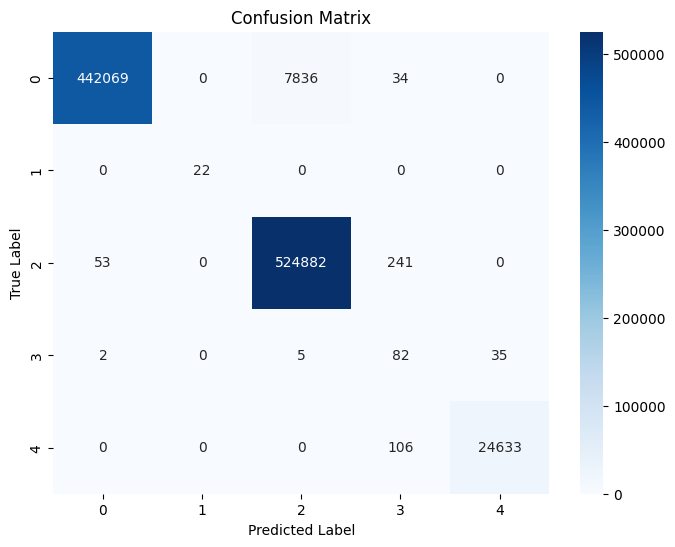

In [34]:
# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC

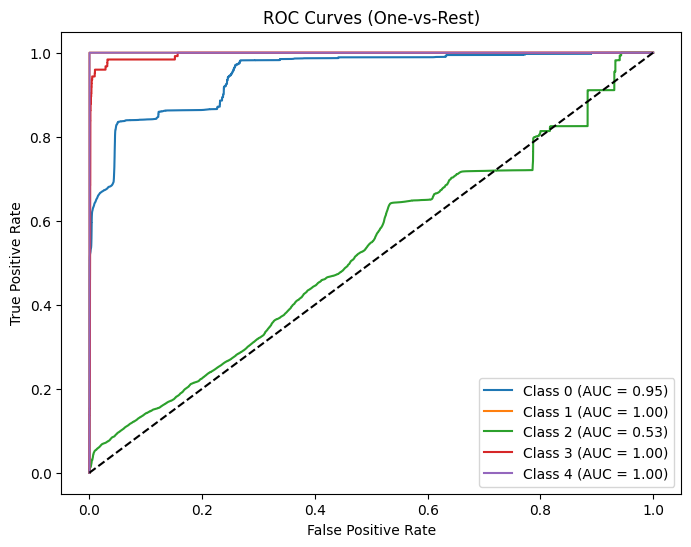

In [35]:
# ROC Curves
y_test_bin = label_binarize(all_targets, classes=range(num_classes))
all_scores = np.array(all_scores)

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

# current B

In [ ]:
# import dask.dataframe as dd
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# import gc

# # Step 1: Inspect the 'category' column
# print("Unique values in 'category':", np.unique(df['category']))
# print("Class distribution before sampling:\n", df['category'].value_counts())

# # Step 2: Combine with Chebyshev distance
# X_static = np.array(df[['pkts', 'bytes', 'sbytes', 'dbytes', 'rate', 'mean', 'stddev', 'sum', 'proto', 'state']].values, dtype=np.float32)
# X_temporal = np.array(df[['stime', 'dur']].values, dtype=np.float32)
# X_static_mean = X_static.mean(axis=1)
# X_static_std = X_static.std(axis=1)
# X_static_reduced = np.vstack([X_static_mean, X_static_std]).T
# chebyshev_dist = np.max(np.abs(X_static_reduced - X_temporal), axis=1)
# X_combined = np.hstack((X_static, chebyshev_dist.reshape(-1, 1)))
# y = np.array(df['category'].values, dtype=np.int64)

# # Free memory
# del df, X_static, X_temporal, X_static_mean, X_static_std, X_static_reduced, chebyshev_dist
# gc.collect()

# # Step 3: Sample to reduce size (target ~5M samples total)
# np.random.seed(42)
# sample_indices = np.random.choice(len(X_combined), size=5_000_000, replace=False)
# X_combined = X_combined[sample_indices]
# y = y[sample_indices]

# # Compute class distribution after sampling
# class_counts_sampled = np.bincount(y)
# print("Class distribution after sampling:", {i: count for i, count in enumerate(class_counts_sampled)})

# # Step 4: Train-test split BEFORE sampling
# X_train, X_test, y_train, y_test = train_test_split(
#     X_combined, y, test_size=0.2, random_state=42, stratify=y
# )

# # Free memory
# del X_combined, y
# gc.collect()

# # Compute class distribution in training set
# class_counts_train = np.bincount(y_train)
# print("Class distribution in training set:", {i: count for i, count in enumerate(class_counts_train)})

# # Step 5: Hybrid Sampling to Balance the Training Set
# # 5.1: Undersample the majority classes (Classes 0, 2, and 4)
# undersampler = RandomUnderSampler(
#     sampling_strategy={
#         0: 50_000,  # Target 50K for Class 0
#         2: 50_000,  # Target 50K for Class 2
#         4: 50_000   # Target 50K for Class 4
#     },
#     random_state=42
# )
# X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# # Free memory
# del X_train, y_train
# gc.collect()

# # Compute class distribution after undersampling
# class_counts_under = np.bincount(y_train_under)
# print("Class distribution after undersampling:", {i: count for i, count in enumerate(class_counts_under)})

# # 5.2: Apply SMOTE to oversample the minority classes (Classes 1, 3)
# smote = SMOTE(
#     random_state=42,
#     sampling_strategy={
#         0: 50_000,  # Already at 50K
#         1: 75_000,  # Oversample to 75K
#         2: 50_000,  # Already at 50K
#         3: 300_000, # Oversample Class 3 more to improve performance
#         4: 50_000   # Already at 50K
#     }
# )
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_under, y_train_under)

# # Add more random noise to synthetic samples to increase diversity
# noise = np.random.normal(0, 0.02, X_train_resampled.shape)  # Increased noise from 0.01 to 0.02
# X_train_resampled += noise

# # Free memory
# del X_train_under, y_train_under
# gc.collect()

# # Compute class distribution after SMOTE
# class_counts_resampled = np.bincount(y_train_resampled)
# print("Class distribution after SMOTE:", {i: count for i, count in enumerate(class_counts_resampled)})

# # Step 6: Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_resampled)
# X_test_scaled = scaler.transform(X_test)

# # Free memory
# del X_train_resampled, X_test
# gc.collect()

# # Step 7: Convert to tensors
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.int64)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# # Free memory
# del X_train_scaled, X_test_scaled, y_train_resampled, y_test
# gc.collect()

# # Step 8: Create DataLoaders
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=4)

# print("Data loading complete! Ready for SpinalSAENet training.")

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np
# from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import label_binarize

# # Define Focal Loss
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=3.0, reduction='mean'):  # Increased gamma to 3.0
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.reduction = reduction
#         self.alpha = alpha  # Class weights

#     def forward(self, inputs, targets):
#         ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
#         pt = torch.exp(-ce_loss)
#         focal_loss = (1 - pt) ** self.gamma * ce_loss
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         return focal_loss

# # Define SpinalSAENet
# class SpinalSAENet(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[128, 64], num_classes=5):  # Reduced hidden dimensions
#         super(SpinalSAENet, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dims[0]),
#             nn.ReLU(),
#             nn.Dropout(0.6),  # Increased dropout to 0.6
#             nn.Linear(hidden_dims[0], hidden_dims[1]),
#             nn.ReLU()
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(hidden_dims[1], 32),
#             nn.ReLU(),
#             nn.Dropout(0.6),  # Increased dropout to 0.6
#             nn.Linear(32, num_classes)
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         output = self.classifier(encoded)
#         return output

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Compute input_dim and num_classes
# input_dim = train_dataset.tensors[0].shape[1]  # 11
# num_classes = len(torch.unique(train_dataset.tensors[1]))  # Should be 5
# print(f"Input dimension: {input_dim}, Number of classes: {num_classes}")

# # Initialize model
# model = SpinalSAENet(input_dim, hidden_dims=[128, 64], num_classes=num_classes)
# model = model.to(device)

# # Class weights (logarithmic inverse frequency)
# y_test = test_dataset.tensors[1].numpy()
# class_counts = np.bincount(y_test)
# print("Class distribution in test set:", {i: count for i, count in enumerate(class_counts)})
# class_weights = np.log(1.0 / class_counts + 1e-6)  # Add small constant to avoid log(0)
# class_weights = class_weights / class_weights.sum() * len(class_counts)
# class_weights = torch.FloatTensor(class_weights).to(device)

# # Use Focal Loss
# criterion_clf = FocalLoss(alpha=class_weights, gamma=3.0)
# optimizer_clf = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  # Increased weight decay
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf, mode='min', factor=0.1, patience=3)
# scaler = torch.cuda.amp.GradScaler()

# print("Training Classifier...")
# best_val_loss = float('inf')
# patience_counter = 0
# patience = 5  # Early stopping patience

# for epoch in range(50):
#     model.train()
#     train_loss = 0.0
#     for data, target in train_loader:
#         data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
#         optimizer_clf.zero_grad()
#         with torch.cuda.amp.autocast():
#             output = model(data)
#             loss = criterion_clf(output, target)
#         if torch.isnan(loss):
#             print("NaN loss detected in training, skipping batch")
#             continue
#         scaler.scale(loss).backward()
#         scaler.step(optimizer_clf)
#         scaler.update()
#         train_loss += loss.item()
    
#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     all_preds = []
#     all_targets = []
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
#             with torch.cuda.amp.autocast():
#                 outputs = model(data)
#                 loss = criterion_clf(outputs, target)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             all_preds.extend(predicted.cpu().numpy())
#             all_targets.extend(target.cpu().numpy())
    
#     val_loss /= len(test_loader)
#     accuracy = np.mean(np.array(all_preds) == np.array(all_targets))
#     f1_weighted = f1_score(all_targets, all_preds, average='weighted')
#     f1_macro = f1_score(all_targets, all_preds, average='macro')
#     precision, recall, f1_per_class, _ = precision_recall_fscore_support(all_targets, all_preds, average=None, zero_division=0)
    
#     print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Test Accuracy: {accuracy*100:.2f}%, F1-Weighted: {f1_weighted:.4f}, F1-Macro: {f1_macro:.4f}")
#     print("Per-class F1-scores:", {f"Class {i}": f1 for i, f1 in enumerate(f1_per_class)})
    
#     scheduler.step(val_loss)
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), "spinal_saenet_best.pth")
#         patience_counter = 0
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Validation loss not improving, stopping training.")
#             break

# # Load best model
# model.load_state_dict(torch.load("spinal_saenet_best.pth"))
# print("Loaded best model with validation loss:", best_val_loss)

# # Generate confusion matrix and ROC curves
# model.eval()
# all_preds = []
# all_targets = []
# all_scores = []
# with torch.no_grad():
#     for data, target in test_loader:
#         data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
#         outputs = model(data)
#         _, predicted = torch.max(outputs, 1)
#         all_preds.extend(predicted.cpu().numpy())
#         all_targets.extend(target.cpu().numpy())
#         all_scores.extend(outputs.cpu().numpy())  # Raw logits

# # Confusion Matrix
# cm = confusion_matrix(all_targets, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# # ROC Curves
# y_test_bin = label_binarize(all_targets, classes=range(num_classes))
# all_scores = np.array(all_scores)

# plt.figure(figsize=(8, 6))
# for i in range(num_classes):
#     fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_scores[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves (One-vs-Rest)")
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# import dask.dataframe as dd

# # Define the path to CSV files
# csv_path = "/kaggle/input/bot-iot/*.csv"

# # Read only the 'category' column, ensuring it's treated as a string
# df = dd.read_csv(csv_path, usecols=['category'], dtype={'category': 'object'})

# # Compute category distribution
# class_counts = df['category'].value_counts().compute()

# # Display class counts
# print(class_counts)


In [ ]:
# import dask.dataframe as dd
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from imblearn.over_sampling import ADASYN  # Use ADASYN instead of SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# import gc

# # Step 1: Inspect the 'category' column
# print("Unique values in 'category':", np.unique(df['category']))
# print("Class distribution before sampling:\n", df['category'].value_counts())

# # Step 2: Combine with Chebyshev distance
# X_static = np.array(df[['pkts', 'bytes', 'sbytes', 'dbytes', 'rate', 'mean', 'stddev', 'sum', 'proto', 'state']].values, dtype=np.float32)
# X_temporal = np.array(df[['stime', 'dur']].values, dtype=np.float32)
# X_static_mean = X_static.mean(axis=1)
# X_static_std = X_static.std(axis=1)
# X_static_reduced = np.vstack([X_static_mean, X_static_std]).T
# chebyshev_dist = np.max(np.abs(X_static_reduced - X_temporal), axis=1)
# X_combined = np.hstack((X_static, chebyshev_dist.reshape(-1, 1)))
# y = np.array(df['category'].values, dtype=np.int64)

# # Free memory
# del df, X_static, X_temporal, X_static_mean, X_static_std, X_static_reduced, chebyshev_dist
# gc.collect()

# # Step 3: Sample to reduce size (target ~5M samples total)
# np.random.seed(42)
# sample_indices = np.random.choice(len(X_combined), size=5_000_000, replace=False)
# X_combined = X_combined[sample_indices]
# y = y[sample_indices]

# # Compute class distribution after sampling
# class_counts_sampled = np.bincount(y)
# print("Class distribution after sampling:", {i: count for i, count in enumerate(class_counts_sampled)})

# # Step 4: Train-test split BEFORE sampling
# X_train, X_test, y_train, y_test = train_test_split(
#     X_combined, y, test_size=0.2, random_state=42, stratify=y
# )

# # Free memory
# del X_combined, y
# gc.collect()

# # Compute class distribution in training set
# class_counts_train = np.bincount(y_train)
# print("Class distribution in training set:", {i: count for i, count in enumerate(class_counts_train)})

# # Step 5: Hybrid Sampling to Balance the Training Set
# # 5.1: Undersample the majority classes (Classes 0, 2, and 4)
# undersampler = RandomUnderSampler(
#     sampling_strategy={
#         0: 50_000,  # Target 50K for Class 0
#         2: 50_000,  # Target 50K for Class 2
#         4: 50_000   # Target 50K for Class 4
#     },
#     random_state=42
# )
# X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# # Free memory
# del X_train, y_train
# gc.collect()

# # Compute class distribution after undersampling
# class_counts_under = np.bincount(y_train_under)
# print("Class distribution after undersampling:", {i: count for i, count in enumerate(class_counts_under)})

# # 5.2: Apply ADASYN to oversample the minority classes (Classes 1, 3)
# adasyn = ADASYN(
#     random_state=42,
#     sampling_strategy={
#         0: 50_000,  # Already at 50K
#         1: 75_000,  # Oversample to 75K
#         2: 50_000,  # Already at 50K
#         3: 150_000, # Reduced oversampling for Class 3
#         4: 75_000   # Oversample to 75K
#     }
# )
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_under, y_train_under)

# # Add random noise to synthetic samples to increase diversity
# noise = np.random.normal(0, 0.02, X_train_resampled.shape)
# X_train_resampled += noise

# # Free memory
# del X_train_under, y_train_under
# gc.collect()

# # Compute class distribution after ADASYN
# class_counts_resampled = np.bincount(y_train_resampled)
# print("Class distribution after ADASYN:", {i: count for i, count in enumerate(class_counts_resampled)})

# # Step 6: Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_resampled)
# X_test_scaled = scaler.transform(X_test)

# # Free memory
# del X_train_resampled, X_test
# gc.collect()

# # Step 7: Convert to tensors
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.int64)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# # Free memory
# del X_train_scaled, X_test_scaled, y_train_resampled, y_test
# gc.collect()

# # Step 8: Create DataLoaders
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=4)

# print("Data loading complete! Ready for SpinalSAENet training.")

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np
# from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import label_binarize

# # Define Focal Loss
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2.5, reduction='mean'):  # Reduced gamma to 2.5
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.reduction = reduction
#         self.alpha = alpha  # Class weights

#     def forward(self, inputs, targets):
#         ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
#         pt = torch.exp(-ce_loss)
#         focal_loss = (1 - pt) ** self.gamma * ce_loss
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         return focal_loss

# # Define SpinalSAENet (unchanged)
# class SpinalSAENet(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[128, 64], num_classes=5):
#         super(SpinalSAENet, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dims[0]),
#             nn.ReLU(),
#             nn.Dropout(0.6),
#             nn.Linear(hidden_dims[0], hidden_dims[1]),
#             nn.ReLU()
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(hidden_dims[1], 32),
#             nn.ReLU(),
#             nn.Dropout(0.6),
#             nn.Linear(32, num_classes)
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         output = self.classifier(encoded)
#         return output

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Compute input_dim and num_classes
# input_dim = train_dataset.tensors[0].shape[1]  # 11
# num_classes = len(torch.unique(train_dataset.tensors[1]))  # Should be 5
# print(f"Input dimension: {input_dim}, Number of classes: {num_classes}")

# # Initialize model
# model = SpinalSAENet(input_dim, hidden_dims=[128, 64], num_classes=num_classes)
# model = model.to(device)

# # Class weights (logarithmic inverse frequency)
# y_test = test_dataset.tensors[1].numpy()
# class_counts = np.bincount(y_test)
# print("Class distribution in test set:", {i: count for i, count in enumerate(class_counts)})
# class_weights = np.log(1.0 / class_counts + 1e-6)  # Add small constant to avoid log(0)
# class_weights = class_weights / class_weights.sum() * len(class_counts)
# class_weights = torch.FloatTensor(class_weights).to(device)

# # Use Focal Loss
# criterion_clf = FocalLoss(alpha=class_weights, gamma=2.5)
# optimizer_clf = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf, mode='min', factor=0.1, patience=3)
# scaler = torch.cuda.amp.GradScaler()

# print("Training Classifier...")
# best_val_loss = float('inf')
# patience_counter = 0
# patience = 5  # Early stopping patience

# for epoch in range(50):
#     model.train()
#     train_loss = 0.0
#     for data, target in train_loader:
#         data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
#         optimizer_clf.zero_grad()
#         with torch.cuda.amp.autocast():
#             output = model(data)
#             loss = criterion_clf(output, target)
#         if torch.isnan(loss):
#             print("NaN loss detected in training, skipping batch")
#             continue
#         scaler.scale(loss).backward()
#         scaler.step(optimizer_clf)
#         scaler.update()
#         train_loss += loss.item()
    
#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     all_preds = []
#     all_targets = []
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
#             with torch.cuda.amp.autocast():
#                 outputs = model(data)
#                 loss = criterion_clf(outputs, target)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             all_preds.extend(predicted.cpu().numpy())
#             all_targets.extend(target.cpu().numpy())
    
#     val_loss /= len(test_loader)
#     accuracy = np.mean(np.array(all_preds) == np.array(all_targets))
#     f1_weighted = f1_score(all_targets, all_preds, average='weighted')
#     f1_macro = f1_score(all_targets, all_preds, average='macro')
#     precision, recall, f1_per_class, _ = precision_recall_fscore_support(all_targets, all_preds, average=None, zero_division=0)
    
#     print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Test Accuracy: {accuracy*100:.2f}%, F1-Weighted: {f1_weighted:.4f}, F1-Macro: {f1_macro:.4f}")
#     print("Per-class F1-scores:", {f"Class {i}": f1 for i, f1 in enumerate(f1_per_class)})
    
#     scheduler.step(val_loss)
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), "spinal_saenet_best.pth")
#         patience_counter = 0
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Validation loss not improving, stopping training.")
#             break

# # Load best model
# model.load_state_dict(torch.load("spinal_saenet_best.pth"))
# print("Loaded best model with validation loss:", best_val_loss)

# # Generate confusion matrix and ROC curves
# model.eval()
# all_preds = []
# all_targets = []
# all_scores = []
# with torch.no_grad():
#     for data, target in test_loader:
#         data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
#         outputs = model(data)
#         _, predicted = torch.max(outputs, 1)
#         all_preds.extend(predicted.cpu().numpy())
#         all_targets.extend(target.cpu().numpy())
#         all_scores.extend(outputs.cpu().numpy())  # Raw logits

# # Confusion Matrix
# cm = confusion_matrix(all_targets, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# # ROC Curves
# y_test_bin = label_binarize(all_targets, classes=range(num_classes))
# all_scores = np.array(all_scores)

# plt.figure(figsize=(8, 6))
# for i in range(num_classes):
#     fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_scores[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves (One-vs-Rest)")
# plt.legend(loc="lower right")
# plt.show()